In [2]:
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Dense, Activation
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import MaxPooling2D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import random, sys
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset ...
#  You will need to seperately download or generate this file
with open("/content/drive/MyDrive/Gdrive/2016.04C.multisnr.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.6)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
testy = list(map(lambda x: mods.index(lbl[x][0]), test_idx))
Y_train = to_categorical(trainy,11)
Y_test = to_categorical(testy,11)


In [6]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(97236, 2, 128) [2, 128]


Build the NN Model

In [7]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Conv2D(256, kernel_size=(1, 3),activation='relu',input_shape=(1,2,128),padding='same'))
model.add(Conv2D(80, kernel_size=(2, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(11, activation='softmax'))
model.add(Reshape([len(classes)]))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 2, 256)         98560     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2, 80)          122960    
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               41216     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2

In [8]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [9]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
95/95 - 27s - loss: 2.3409 - accuracy: 0.2030 - val_loss: 2.0826 - val_accuracy: 0.2477
Epoch 2/100
95/95 - 10s - loss: 2.0203 - accuracy: 0.2748 - val_loss: 1.9209 - val_accuracy: 0.3284
Epoch 3/100
95/95 - 10s - loss: 1.8258 - accuracy: 0.3551 - val_loss: 1.7706 - val_accuracy: 0.3906
Epoch 4/100
95/95 - 10s - loss: 1.7167 - accuracy: 0.4002 - val_loss: 1.6632 - val_accuracy: 0.4133
Epoch 5/100
95/95 - 10s - loss: 1.6003 - accuracy: 0.4239 - val_loss: 1.5673 - val_accuracy: 0.4378
Epoch 6/100
95/95 - 10s - loss: 1.4696 - accuracy: 0.4651 - val_loss: 1.3933 - val_accuracy: 0.4927
Epoch 7/100
95/95 - 10s - loss: 1.2743 - accuracy: 0.5184 - val_loss: 1.2408 - val_accuracy: 0.5286
Epoch 8/100
95/95 - 10s - loss: 1.1660 - accuracy: 0.5561 - val_loss: 1.1773 - val_accuracy: 0.5624
Epoch 9/100
95/95 - 10s - loss: 1.0942 - accuracy: 0.5867 - val_loss: 1.1350 - val_accuracy: 0.5776
Epoch 10/100
95/95 - 10s - loss: 1.0556 - accuracy: 0.6012 - val_loss: 1.1097 - val_accuracy: 0.5869

In [10]:
ls

convmodrecnets_CNN2_0.5.wts.h5  drive/  sample_data/


In [11]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.096913456916809, 0.6069665551185608]


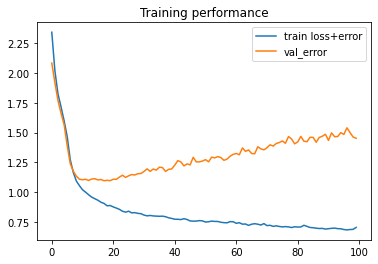

In [12]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

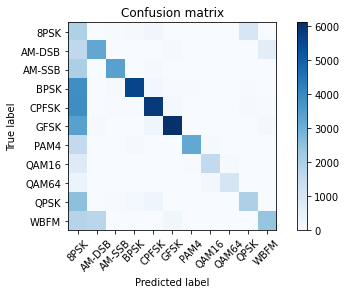

In [14]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
predicted_classes1 = np.argmax(np.round(test_Y_hat), axis=1)
from sklearn.metrics import confusion_matrix
confnorm = confusion_matrix(testy, predicted_classes1)
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.1593711467324291
Overall Accuracy:  0.15664508171446193
Overall Accuracy:  0.1579754601226994
Overall Accuracy:  0.16309412861137
Overall Accuracy:  0.178743961352657
Overall Accuracy:  0.22308168316831684
Overall Accuracy:  0.3782874617737003
Overall Accuracy:  0.5250856964786538
Overall Accuracy:  0.6627906976744186
Overall Accuracy:  0.7916028194912657
Overall Accuracy:  0.8456086286594762
Overall Accuracy:  0.8558081594518842
Overall Accuracy:  0.8680981595092024
Overall Accuracy:  0.863342566943675
Overall Accuracy:  0.8660301817061903
Overall Accuracy:  0.8967524509803921
Overall Accuracy:  0.9074700276667691
Overall Accuracy:  0.8501720362840163
Overall Accuracy:  0.8779357231149567
Overall Accuracy:  0.9222428748451054


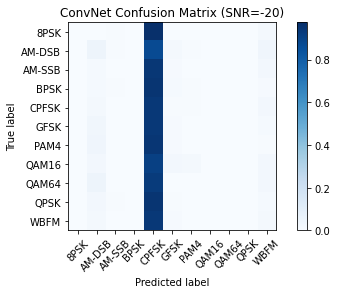

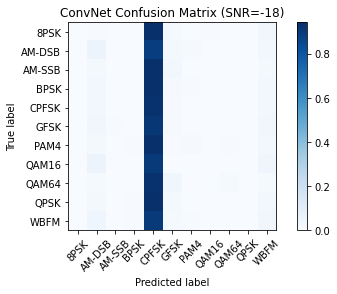

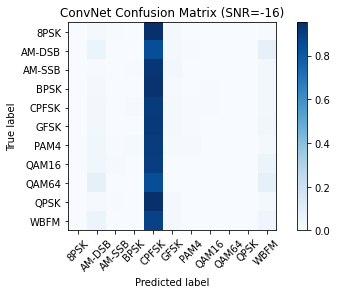

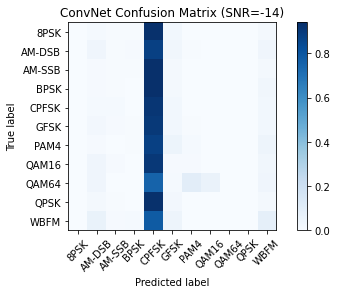

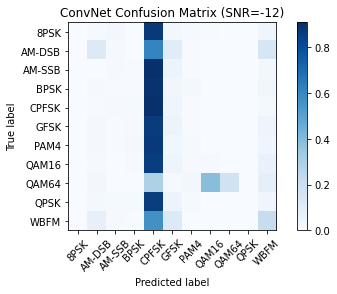

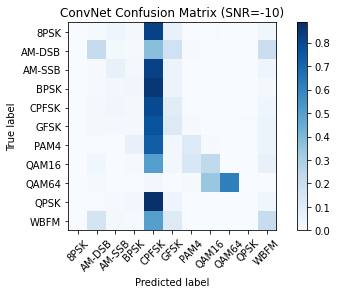

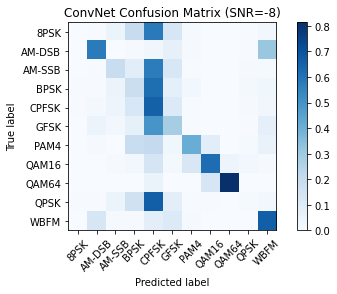

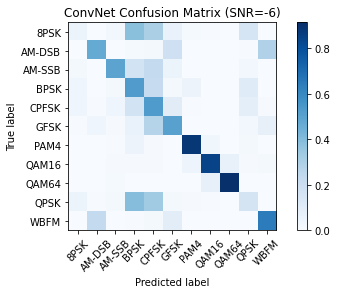

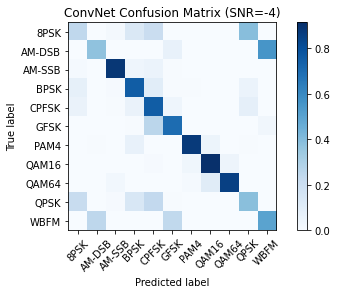

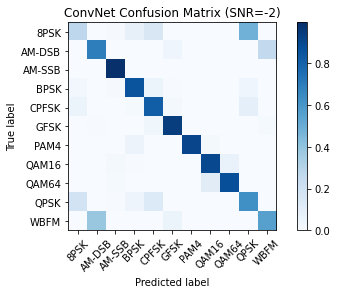

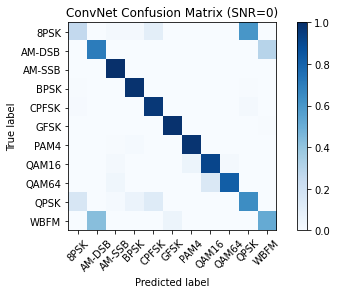

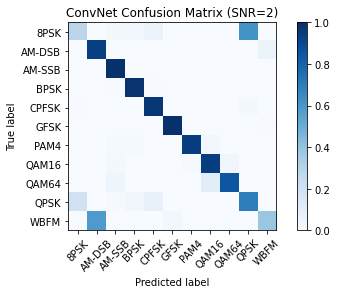

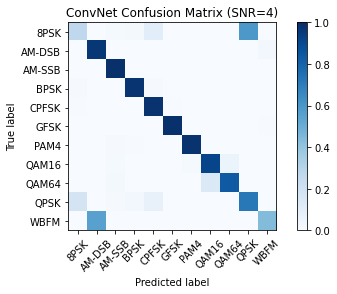

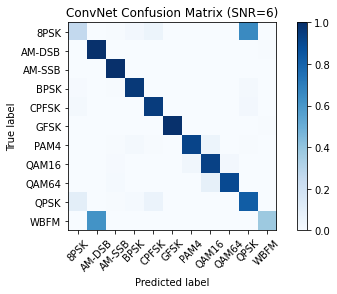

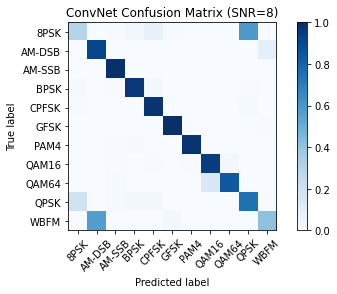

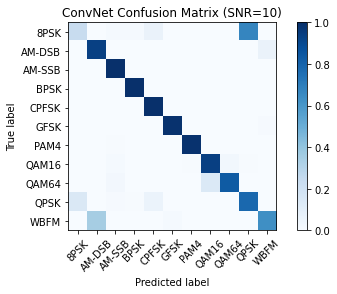

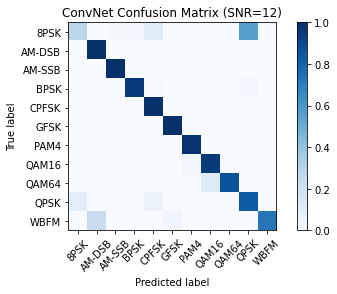

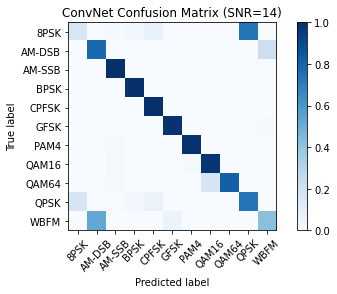

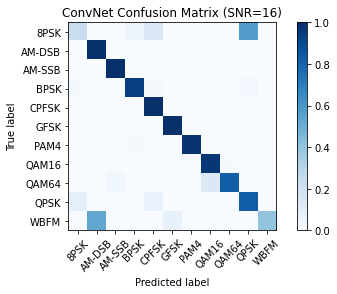

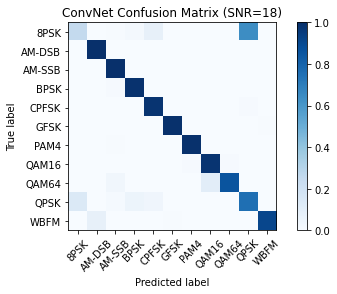

In [15]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [16]:
# Save results to a pickle file for plotting later
#print acc
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

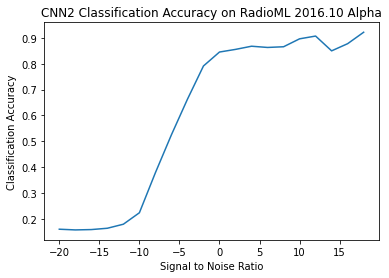

In [17]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")